In [ ]:
import pandas as pd
import seaborn as sns
%matplotlib inline

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare df

In [ ]:
df = pd.read_csv('./drive/My Drive/ronbun/framenet_dataset.csv')

In [ ]:
df = df.groupby('label').filter(lambda x : len(x) > 100)
df = df[df['label'] != 'degree']

In [ ]:
df['sent_text'] = df['sent_text'].astype(str)

### Train

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

#do not forget manually change labels if you want to do in with another data or another frames, also you can use sklearn.preprocessing LabelEncoder
labels = {'experiencer': 0,
          'stimulus': 1,
          'expressor': 2,
          'topic': 3,
          'circumstances': 4}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['sent_text']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

3849 481 482


In [ ]:
class SRLGPT2Classifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SRLGPT2Classifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
# EPOCHS = 5
# # model = SRLGPT2Classifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
# model = SRLGPT2Classifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
# LR = 1e-6

# train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 1925/1925 [01:58<00:00, 16.22it/s]


Epochs: 1 | Train Loss:  0.584             | Train Accuracy:  0.558             | Val Loss:  0.548             | Val Accuracy:  0.601


100%|██████████| 1925/1925 [01:57<00:00, 16.34it/s]


Epochs: 2 | Train Loss:  0.526             | Train Accuracy:  0.587             | Val Loss:  0.539             | Val Accuracy:  0.593


100%|██████████| 1925/1925 [01:58<00:00, 16.30it/s]


Epochs: 3 | Train Loss:  0.486             | Train Accuracy:  0.592             | Val Loss:  0.529             | Val Accuracy:  0.584


100%|██████████| 1925/1925 [01:57<00:00, 16.32it/s]


Epochs: 4 | Train Loss:  0.443             | Train Accuracy:  0.617             | Val Loss:  0.531             | Val Accuracy:  0.549


100%|██████████| 1925/1925 [01:57<00:00, 16.36it/s]


Epochs: 5 | Train Loss:  0.406             | Train Accuracy:  0.636             | Val Loss:  0.521             | Val Accuracy:  0.495


In [ ]:
EPOCHS = 4

model = SRLGPT2Classifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 1925/1925 [01:57<00:00, 16.35it/s]


Epochs: 1 | Train Loss:  0.600             | Train Accuracy:  0.552             | Val Loss:  0.543             | Val Accuracy:  0.588


100%|██████████| 1925/1925 [01:59<00:00, 16.10it/s]


Epochs: 2 | Train Loss:  0.534             | Train Accuracy:  0.581             | Val Loss:  0.556             | Val Accuracy:  0.484


100%|██████████| 1925/1925 [01:58<00:00, 16.31it/s]


Epochs: 3 | Train Loss:  0.494             | Train Accuracy:  0.589             | Val Loss:  0.523             | Val Accuracy:  0.582


100%|██████████| 1925/1925 [01:57<00:00, 16.32it/s]


Epochs: 4 | Train Loss:  0.450             | Train Accuracy:  0.610             | Val Loss:  0.535             | Val Accuracy:  0.538


### Model evaluation

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()


    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            true_labels += test_label.cpu().numpy().flatten().tolist()
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.600


### Confusion Matrix visualization

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 2.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

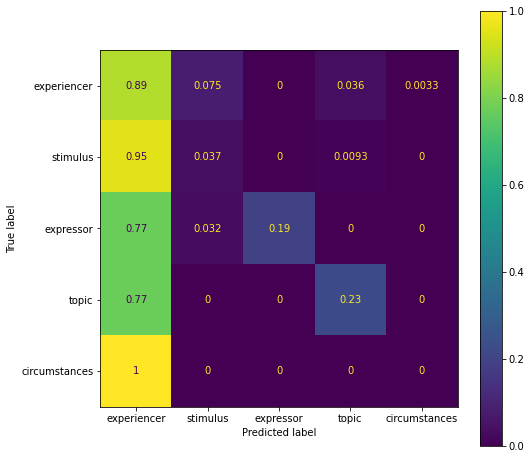

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)